An example of using gcamwrapper to highlight at a high level capabilities that could be useful for a number of tasks ranging from day to day work such as debgging or prototying, enabaling new expiriments such as coupling to other models, or new / more flexible method to run existing expiriments.

In [1]:
# general purpose package
import time
import pkg_resources

import pandas as pd
import numpy as np

# load GCAM via gcamwrapper
import gcamwrapper as gw

/tmp/ipykernel_2079/335544381.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


To interact with GCAM we create a GCAM object and to do that we need to simply provide a configuration XML and the appropriate working directory from which to run.

In [2]:
# path to the exe directory where gcam-core is installed
core_exe_path = 'exe'

# path to the xml configuration file you want to use
config_xml_file = 'configuration.xml'

Here we can observe the typical GCAM messages.  It will go through the steps of parsing all XMLs and other intitializations (`completeInit`) so that it is in a state that is ready to run model periods.

In [3]:
%%time

g = gw.Gcam(config_xml_file, core_exe_path)

Running GCAM model code base version 7.1 revision gcam-v7.1

Configuration file:  configuration.xml
Parsing input files...
Parsing ./hector.xml scenario component.
Parsing ../../data/gcamdata/xml/socioeconomics_gSSP2.xml scenario component.
Parsing ../../data/gcamdata/xml/resources.xml scenario component.
Parsing ../../data/gcamdata/xml/en_supply.xml scenario component.
Parsing ../../data/gcamdata/xml/en_transformation.xml scenario component.
Parsing ../../data/gcamdata/xml/electricity_water.xml scenario component.
Parsing ../../data/gcamdata/xml/heat.xml scenario component.
Parsing ../../data/gcamdata/xml/hydrogen.xml scenario component.
Parsing ../../data/gcamdata/xml/en_distribution.xml scenario component.
Parsing ../../data/gcamdata/xml/other_industry.xml scenario component.
Parsing ../../data/gcamdata/xml/other_industry_incelas_gssp2.xml scenario component.
Parsing ../../data/gcamdata/xml/iron_steel.xml scenario component.
Parsing ../../data/gcamdata/xml/iron_steel_incelas_gssp2.x

Now we can start to interact with the GCAM object as we choose.  We will start by just running out several model periods.  `gcamwrapper` includes some handy utility methods such as to translate model years to periods.

In [4]:
%%time

g.run_period(g.convert_year_to_period(2050))

Starting a model run. Running period 11
Model run beginning.
Period 0: 1975
Model solved with last period's prices.

Period 1: 1990
Model solved normally. Iterations period 1: 109. Total iterations: 110

Period 2: 2005
Model solved normally. Iterations period 2: 102. Total iterations: 211

Period 3: 2010
Model solved normally. Iterations period 3: 163. Total iterations: 374

Period 4: 2015
Model solved normally. Iterations period 4: 112. Total iterations: 485

Period 5: 2020
Model solved normally. Iterations period 5: 799. Total iterations: 1284

Period 6: 2025
Model solved normally. Iterations period 6: 186. Total iterations: 1470

Period 7: 2030
Model solved normally. Iterations period 7: 200. Total iterations: 1669

Period 8: 2035
Model solved normally. Iterations period 8: 159. Total iterations: 1828

Period 9: 2040
Model solved normally. Iterations period 9: 413. Total iterations: 2240

Period 10: 2045
Model solved normally. Iterations period 10: 148. Total iterations: 2387

Perio

Next I'll introduce the `SolutionDebugger` object which is also part of the `gcamwrapper` package.  Naturally it is useful for solution debugging.  Which may not be that interesting for most folks.  So I won't dwell on it.  It does however include a method, `evaluate`, which can be used to run a single iteration of GCAM.

In [5]:
# the default is to create the debugger at the last period run and all solvable markets
# however you could choose any previous period or supply a solution info using the same
# syntax as in the solver config such as:
# g.create_solution_debugger(market_filter = "solvable && unsolved")
sd = g.create_solution_debugger()

Save the initial prices so we can get back to them if necessary.

It is also a good time to point out that the solver wants to work in "scaled" or normalized units.  This of course isn't always meaningful to the modelers so the `SolutionDebugger` methods can be configured to give values in either `scaled` (`True`) or actual units (`False`).

In [6]:
x0 = sd.get_prices(True)
prices0 = sd.get_prices(False)

The `SolutionDebugger` methods return a vector of values.  However, these vectors are "named" with the market names which is quite handy to quickly understand what the values are

In [7]:
sd.get_prices(False)[0:5]

globaloil-credits    -3.508748
USAcoal               0.560832
USAcrude oil          4.774804
USAnatural gas        2.031746
globaluranium        80.682250
dtype: float64

Or to index the vector directly

In [8]:
sd.get_supply(False)['USACorn']

np.float64(593.4746940376657)

A basic usage for this tool would be to map out supply and demand curves.

To do so we can organize the steps into a function which we can then call over a vector of prices and markets

In [9]:
def calc_supply_demand(sd, rel_prices, markets):
    # loop over prices and colect results
    return_dfs = []
    for rel_price in rel_prices:
        # I like to scale prices using relative values
        # You could of course send actual prices in which case start with prices0
        x = x0.copy()
        x[markets] *= rel_price
        
        # Now we can run an interation at this new price
        # We started from "scaled" prices so we need to tell evaluate so to let it know
        # it doesn't need to rescale them.
        # Also we don't want to reset the model back to the previous state so that we can
        # collect some additional information beyond the `F(x)` (demand - supply) which is
        # returned by the method
        fx = sd.evaluate(x, scaled = True, reset = False)
        
        # collect results in a DataFrame from which we can plot results later
        df = pd.DataFrame(data={"market": markets,
                                "price": sd.get_prices(False)[markets],
                                "fx": fx[markets],
                                "supply": sd.get_supply(False)[markets],
                                "demand": sd.get_demand(False)[markets]},
                         index=markets)
        return_dfs.append(df)
    return pd.concat(return_dfs)

Change USA biomass prices from 50% to 500% the solved value evenly spaced over 50 points

In [10]:
bio_sd = calc_supply_demand(sd, np.linspace(0.5, 5.0, 50), ['USAbiomass'])
bio_sd.head()

,market,price,fx,supply,demand
USAbiomass,USAbiomass,0.553344,4.625742,1.601397,42.174088
USAbiomass,USAbiomass,0.654979,3.938991,1.974341,36.523495
USAbiomass,USAbiomass,0.756614,2.959414,2.863243,28.820461
USAbiomass,USAbiomass,0.858248,1.905013,4.238834,20.947826
USAbiomass,USAbiomass,0.959883,0.978192,6.032081,14.611871


Plot up the supply and demand curves

mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-nphl0dgn because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


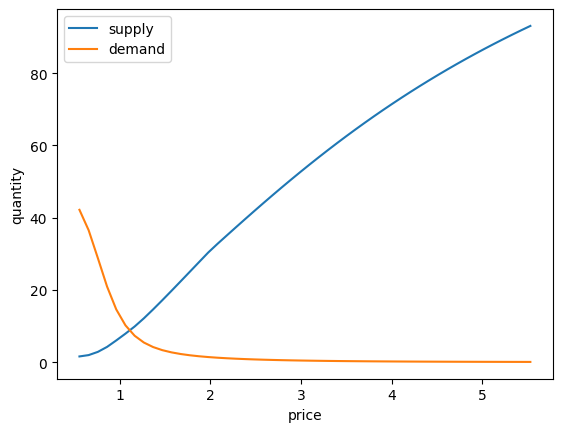

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(bio_sd.price, bio_sd.supply, label="supply")
ax.plot(bio_sd.price, bio_sd.demand, label="demand")
ax.set_ylabel("quantity")
ax.set_xlabel("price")
ax.legend()

Now we switch gears and talk about how to get and set arbitrary GCAM parameters / results.

Given the heirarchical nature of the way this data is represented in GCAM we continue to need some sort of queries which look _something_ like XPath queries such as those used with the output databases.  So similar to the output database we include a Query library which we have pre-populated query library in a YAML file included with the `gcamwrapper` package.  However, given we are alredy in `python` where we can easily filter,  summarize, etc the queries tend to be less detailed.

In [12]:
from gcamwrapper.query_library import PACKAGE_QUERIES

The queries have been organized into the following categores

In [13]:
PACKAGE_QUERIES.keys()

dict_keys(['resource', 'electricity', 'refining', 'buildings', 'industry', 'transportation', 'socioeconomic', 'emissions', 'ag', 'land', 'water', 'market'])

And with in these categores we see some common queries to get results such as outputs or inputs and parameters such as share weights, IO coefficients, or costs.

In [14]:
PACKAGE_QUERIES['transportation'].keys()

dict_keys(['service', 'input', 'sector_cost', 'tech_cost', 'subsector_share_weight', 'tech_share_weight', 'input_coef', 'non_energy_cost'])

Again the query looks something like XPath.  Altough you will note that in a bunch of these categories we see `region{region@name}` place holders.  These will basically be the columns you get in your output.  `gcamwrapper` will allow you to use some higher level sytax to apply filters in these place holders, but again, given the flexibility of doing this in `python` itself often just leaving the default (get all values) is good enough.

In [15]:
trn_cost_query = gw.get_query('transportation', 'non_energy_cost')
trn_cost_query

'world/region{region@name}/sector[+NamedFilter,StringRegexMatches,^trn_]/subsector{subsector@name}/technology{tech@name}/period{vintage@year}/input{input@name}/adjusted-cost{year@year}'

We can then just call `get_data` on the GCAM object with the query we want.

In [16]:
trn_cost_df = g.get_data(trn_cost_query, vintage = ["=", g.get_current_year()])
trn_cost_df.head()

,region,sector,subsector,technology,period,input,year,adjusted-cost
0,Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,27.5957
1,Africa_Eastern,trn_aviation_intl,International Aviation,Hydrogen,2050,non-energy,2050,25.0106
2,Africa_Eastern,trn_aviation_intl,International Aviation,Liquids,2050,non-energy,2050,12.3702
3,Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,3.7250
4,Africa_Eastern,trn_freight,Domestic Ship,FCEV,2050,non-energy,2050,1.5743


Now lets use this capability to do something _interesting_.  Here we do a little experiment to scale our Core assumptions about battery / capital costs for battery electric vehicles and see what that does to fuel consumption in the transportation sector.

In [17]:
# save the core value so we can get back to it later
core_BEV = trn_cost_df.query("technology == 'BEV'")

Get the query for transport fuel consumption (input) and some mappings to aggregate / filter the fuels).

In [18]:
trn_input_query = gw.get_query("transportation", "input")

trn_fuel_map = pd.DataFrame({"fuel": ["H2", "H2", "coal", "gas", "elec", "liquids"]},
                           index=["H2 retail dispensing", "H2 wholesale dispensing",
                                  "delivered coal", "delivered gas", "elect_td_trn",
                                  "refined liquids enduse"])

Organize the steps into a function so we can run the expirment over a vector of sensitiviy values.  Here we will do a simple test to see what happens as a first degree effect (out of equalibrium).

In [19]:
def calc_bev_eval(sens_mults):
    # loop over sensitivities and colect results
    return_dfs = []
    for sens in sens_mults:
        # start with the Core assumption and scale BEV costs by the current sens
        new_costs = core_BEV.copy()
        new_costs['adjusted-cost'] *= sens
        # to update the parameters in GCAM we can just call `set_data` with
        # the GCAM object, the DataFrame with values to update, and the same
        # query we used to query the data in the first place
        g.set_data(new_costs, trn_cost_query)
        
        # run a single iteration using the solved prices
        # again, do not reset after so that we can collect some results
        sd.evaluate(x0, True, False)
        
        # grab the transport fuel consumption and aggregate so we can plot up some
        # results
        trn_input_df = g.get_data(trn_input_query, year = ["=", g.get_current_year()])
        trn_fuel_agg = trn_fuel_map.merge(trn_input_df.groupby(["input"]).sum(["physical-demand"]), left_index=True, right_index=True)
        trn_fuel_agg['sens'] = sens
        trn_fuel_agg = trn_fuel_agg.pivot_table(index=["sens"], columns=["fuel"], values=["physical-demand"], aggfunc="sum")
        return_dfs.append(trn_fuel_agg)
    return pd.concat(return_dfs)

Run the sensitivity at 1 (core value), 50%, and 10%

In [20]:
sens_out = calc_bev_eval([1.0, 0.5, 0.1])

Plot results

<Axes: xlabel='sens'>

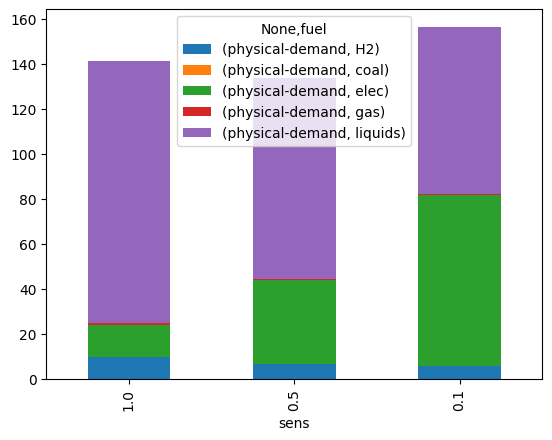

In [21]:
sens_out.plot.bar(stacked=True)

Just double checking the costs indeed updated as expected

In [22]:
g.get_data(trn_cost_query, vintage = ["=", g.get_current_year()], tech = ["=", "BEV"]).head()

,region,sector,subsector,technology,period,input,year,adjusted-cost
0,Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,2.75957
1,Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,0.37250
2,Africa_Eastern,trn_freight,Freight Rail,BEV,2050,non-energy,2050,2.10886
3,Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2050,0.04180
4,Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2055,0.04180


The real value of doing these experiments in GCAM is to include second order effects.  So lets do it again but this time re-solving.

In [23]:
def calc_bev_solve(sens_mults):
    # loop over sensitivities and colect results
    # Oops, we have to use a slightly different query otherwise the value we want
    # to set gets replaced with the parsed value in `initCalc`
    input_cost_query = 'world/region{region@name}/sector[+NamedFilter,StringRegexMatches,^trn_]/subsector{subsector@name}/technology{tech@name}/period{vintage@year}/input{input@name}/input-cost'
    return_dfs = []
    for sens in sens_mults:
        # start with the Core assumption and scale BEV costs by the current sens
        new_costs = core_BEV.copy()
        new_costs['adjusted-cost'] *= sens
        new_costs.drop(columns="year", inplace=True)
        # set the data, same as before
        g.set_data(new_costs, input_cost_query)
        
        # We can ask it to re-run whenever we want.  It keeps track of what has been
        # run already to this call will only re-run 2050.
        g.run_period(g.get_current_period())
        
        # grab the transport fuel consumption and aggregate so we can plot up some
        # results
        trn_input_df = g.get_data(trn_input_query, year = ["=", g.get_current_year()])
        trn_fuel_agg = trn_fuel_map.merge(trn_input_df.groupby(["input"]).sum(["physical-demand"]), left_index=True, right_index=True)
        trn_fuel_agg['sens'] = sens
        trn_fuel_agg = trn_fuel_agg.pivot_table(index=["sens"], columns=["fuel"], values=["physical-demand"], aggfunc="sum")
        return_dfs.append(trn_fuel_agg)
    return pd.concat(return_dfs)

Run the sensitivity at 1 (core value), 50%, and 10%

Obviously this will take longer to run

In [24]:
sens_out = calc_bev_solve([1.0, 0.5, 0.1])

Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 291. Total iterations: 3022
Mon Apr 28 02:23:27 2025:WARNING:printLogHeader: hector version 3.2.0

All model periods solved correctly.
Mon Apr 28 02:23:46 2025:WARNING:printLogHeader: hector version 3.2.0
Model run completed.
Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 159. Total iterations: 3181

Mon Apr 28 02:24:08 2025:WARNING:printLogHeader: hector version 3.2.0
All model periods solved correctly.
Model run completed.
Mon Apr 28 02:24:26 2025:WARNING:printLogHeader: hector version 3.2.0
Starting a model run. Running period 11
Model run beginning.
Period 11: 2050
Model solved normally. Iterations period 11: 181. Total iterations: 3362

Mon Apr 28 02:24:49 2025:WARNING:printLogHeader: hector version 3.2.0
All model periods solved correctly.
Mon Apr 28 02:25:08 2025:WARNING:printLogHeader

Plot results

<Axes: xlabel='sens'>

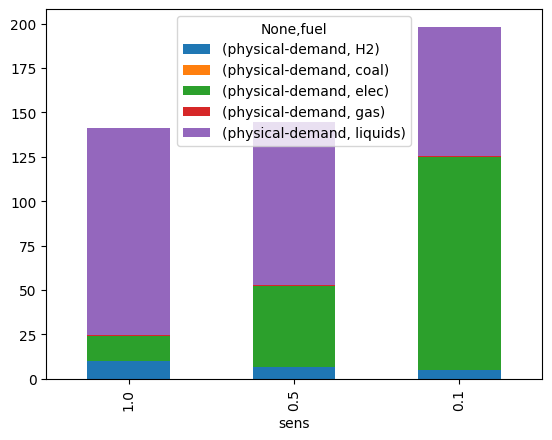

In [25]:
sens_out.plot.bar(stacked=True)

Just double checking the costs indeed updated as expected

In [26]:
g.get_data(trn_cost_query, vintage = ["=", g.get_current_year()], tech = ["=", "BEV"]).head()

,region,sector,subsector,technology,period,input,year,adjusted-cost
0,Africa_Eastern,trn_aviation_intl,International Aviation,BEV,2050,non-energy,2050,2.75957
1,Africa_Eastern,trn_freight,Domestic Ship,BEV,2050,non-energy,2050,0.37250
2,Africa_Eastern,trn_freight,Freight Rail,BEV,2050,non-energy,2050,2.10886
3,Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2050,0.04180
4,Africa_Eastern,trn_freight_road,Heavy truck,BEV,2050,non-energy,2055,0.04180
